In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os


class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: '/Users/royruiz/SimCN/a-team-2/SiMCN-Ex07/New_results/NO_VOIP_DSL_rpt03_scenario_02_throughput.csv',
                 2: '/Users/royruiz/SimCN/a-team-2/SiMCN-Ex07/New_results/NO_VOIP_DSL_rpt10_scenario_02_throughput.csv',
                 3: '/Users/royruiz/SimCN/a-team-2/SiMCN-Ex07/New_results/NO_VOIP_DSL_rpt30_scenario_02_throughput.csv',
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'throughput']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)
        
        df = pd.DataFrame(data)
        
        avgTP_1000s_arr = []
        avgTP_3000s_arr = []
        avgTP_5000s_arr = []

        for i in range(len(data)):
            if (df['timelimit'][i] == 500):
                avgTP_1000s_arr.append(df['throughput'][i])
            elif (df['timelimit'][i] == 1000):
                avgTP_3000s_arr.append(df['throughput'][i])
            elif (df['timelimit'][i] == 2500):
                avgTP_5000s_arr.append(df['throughput'][i])
                
        arrays = {'array_1000': avgTP_1000s_arr, 
                  'array_300': avgTP_3000s_arr,
                  'array_5000': avgTP_5000s_arr
                 }
        return arrays
    
    # Sample variance = SUM((x_i - x_bar)^2) / (n - 1)
    # Sample standard deviation = sqrt(sample variance)
    
    # sampleVariance = 0
    # for i, val in enumerate(arr):
    #    sampleVariance += (val - sampleMean(arr))**2
    # sampleVariance = sampleVariance / (len(arr) - 1)
    # return math.sqrt(sampleVariance)
    
    def SampleStDev(self, arrays):
        sample_stdev = []
        for key, value in arrays.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arrays):
        sample_mean = []
        for key, value in arrays.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arrays):
        t_scores = []
        for inner_array in arrays.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, conf, arrays, sample_mean, sample_stdev, t_scores):
        for inner_array in arrays.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arrays, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arrays.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        for number in range(1,4):
            file_number = number

            obj = Result_Analysis()
            mean = obj.sampleMean(obj.read_file(file_number))
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(obj.read_file(file_number))
            tscore = obj.tScore(confidence_interval, obj.read_file(file_number))

            t_score_l, t_score_r = obj.confInterval_t(confidence_interval, obj.read_file(file_number), mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, obj.read_file(file_number), mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
            
        
        #Plot the data
            
        # width of the bars
        barWidth = 0.12
 
        # Choose the height of the bars
        bars_1000s = [mean_dict[i][0] for i in mean_dict]
        bars_3000s = [mean_dict[i][1] for i in mean_dict]
        bars_5000s = [mean_dict[i][2] for i in mean_dict]
        
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        yer_1000s_l = [t_dict[1][0][0], t_dict[2][0][0], z_dict[3][0][0]]
        yer_1000s_u = [t_dict[1][0][1], t_dict[2][0][1], z_dict[3][0][1]]
        
        yer_3000s_l = [t_dict[1][1][0], t_dict[2][1][0], z_dict[3][1][0]]
        yer_3000s_u = [t_dict[1][1][1], t_dict[2][1][1], z_dict[3][1][1]]
        
        yer_5000s_l = [t_dict[1][2][0], t_dict[2][2][0], z_dict[3][2][0]]
        yer_5000s_u = [t_dict[1][2][1], t_dict[2][2][1], z_dict[3][2][1]]
        
        # Choose the height of the confidence interval (error bars) for errorbar method
        yer_1000s = [(u - l)/2 for u, l in zip(yer_1000s_u, yer_1000s_l)]
        yer_3000s = [(u - l)/2 for u, l in zip(yer_3000s_u, yer_3000s_l)]
        yer_5000s = [(u - l)/2 for u, l in zip(yer_5000s_u, yer_5000s_l)]
        
        # The x position of bars
        r_1000s = np.arange(len(bars_1000s))
        r_3000s = [x + barWidth for x in r_1000s]
        r_5000s = [x + barWidth for x in r_3000s]

        plt.figure(figsize = (15,8))
        
        # Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#333F4B'
        plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 14})
        
        # Create 1000s bars
        plt.bar(r_1000s, bars_1000s, width = barWidth, color = '#ed8f72', label='1000 Seconds')
        plt.errorbar(r_1000s, bars_1000s, yerr=yer_1000s, color = 'black', capthick=2, capsize=5, fmt=' ')
        plt.fill_between(r_1000s, yer_1000s_l, yer_1000s_u, facecolor='Purple', alpha=0.3, zorder=2)
        
        # Create 3000s bars
        plt.bar(r_3000s, bars_3000s, width = barWidth, color = '#d6d727', label='3000 Seconds')
        plt.errorbar(r_3000s, bars_3000s, yerr=yer_3000s, color = 'black', capthick=2, capsize=5, fmt=' ')
        plt.fill_between(r_3000s, yer_3000s_l, yer_3000s_u, facecolor='Purple', alpha=0.3, zorder=2)
        
        # Create 5000s bars
        plt.bar(r_5000s, bars_5000s, width = barWidth, color = '#92cad1', label='5000 Seconds')
        plt.errorbar(r_5000s, bars_5000s, yerr=yer_5000s, color = 'black', capthick=2, capsize=5, fmt=' ')
        plt.fill_between(r_5000s, yer_5000s_l, yer_5000s_u, facecolor='Purple', alpha=0.3, zorder=2)
        
        # General layout
        plt.xticks([r + barWidth for r in range(len(bars_1000s))], ['3 Runs\nn <= 30\nUses T-Score',
                                                                  '10 Runs\nn <= 30\nUses T-Score',
                                                                  '30 Runs\nn = 30\nUses Z-Score'])
        plt.yticks(np.arange(0, 3000, 1000))
        plt.ticklabel_format(axis='y', style='sci', scilimits=(5,5), useMathText=True)
        
        plt.ylabel('Average Throughput (bits/sec)')
        plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.03), ncol=3,
            borderaxespad=0, frameon=False)

        # Show graphic
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 


Please enter the desired confidence interval: .95


StatisticsError: mean requires at least one data point


Please enter the desired confidence interval: 0.95


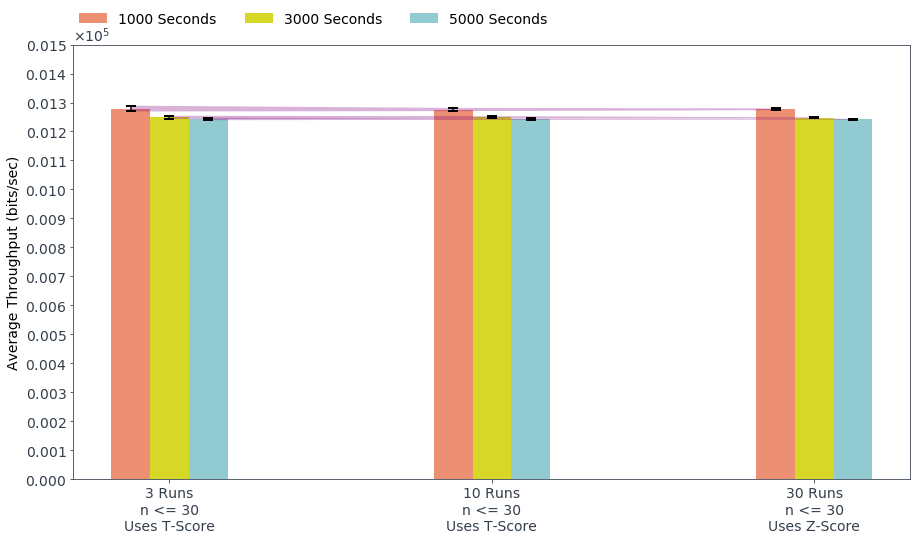

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats


class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: 'NO_VOIP_ISDN_rpt03_scenario_01.csv',
                 2: 'NO_VOIP_ISDN_rpt10_scenario_01.csv',
                 3: 'NO_VOIP_ISDN_rpt30_scenario_01.csv',
                }
        cols = ['run', 'repetition', 'Module', 'Name', 'throughput', 'timelimit']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        df = pd.DataFrame(data)
        
        avgTP_1000s_arr = []
        avgTP_3000s_arr = []
        avgTP_5000s_arr = []

        for i in range(len(data)):
            if (df['timelimit'][i] == 1000):
                avgTP_1000s_arr.append(df['throughput'][i])
            elif (df['timelimit'][i] == 3000):
                avgTP_3000s_arr.append(df['throughput'][i])
            elif (df['timelimit'][i] == 5000):
                avgTP_5000s_arr.append(df['throughput'][i])
                
        arrays = {'array_1000': avgTP_1000s_arr, 
                  'array_300': avgTP_3000s_arr,
                  'array_5000': avgTP_5000s_arr
                 }
        return arrays
    
    # Sample variance = SUM((x_i - x_bar)^2) / (n - 1)
    # Sample standard deviation = sqrt(sample variance)
    
    # sampleVariance = 0
    # for i, val in enumerate(arr):
    #    sampleVariance += (val - sampleMean(arr))**2
    # sampleVariance = sampleVariance / (len(arr) - 1)
    # return math.sqrt(sampleVariance)
    
    def SampleStDev(self, arrays):
        sample_stdev = []
        for key, value in arrays.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arrays):
        sample_mean = []
        for key, value in arrays.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arrays):
        t_scores = []
        for inner_array in arrays.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, conf, arrays, sample_mean, sample_stdev, t_scores):
        for inner_array in arrays.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arrays, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arrays.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        for number in range(1,4):
            file_number = number

            obj = Result_Analysis()
            mean = obj.sampleMean(obj.read_file(file_number))
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(obj.read_file(file_number))
            tscore = obj.tScore(confidence_interval, obj.read_file(file_number))

            t_score_l, t_score_r = obj.confInterval_t(confidence_interval, obj.read_file(file_number), mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, obj.read_file(file_number), mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
            
        
        #Plot the data
            
        # width of the bars
        barWidth = 0.12
 
        # Choose the height of the bars
        bars_1000s = [mean_dict[i][0] for i in mean_dict]
        bars_3000s = [mean_dict[i][1] for i in mean_dict]
        bars_5000s = [mean_dict[i][2] for i in mean_dict]
        
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        yer_1000s_l = [t_dict[1][0][0], t_dict[2][0][0], z_dict[3][0][0]]
        yer_1000s_u = [t_dict[1][0][1], t_dict[2][0][1], z_dict[3][0][1]]
        
        yer_3000s_l = [t_dict[1][1][0], t_dict[2][1][0], z_dict[3][1][0]]
        yer_3000s_u = [t_dict[1][1][1], t_dict[2][1][1], z_dict[3][1][1]]
        
        yer_5000s_l = [t_dict[1][2][0], t_dict[2][2][0], z_dict[3][2][0]]
        yer_5000s_u = [t_dict[1][2][1], t_dict[2][2][1], z_dict[3][2][1]]
        
        # Choose the height of the confidence interval (error bars) for errorbar method
        yer_1000s = [(u - l)/2 for u, l in zip(yer_1000s_u, yer_1000s_l)]
        yer_3000s = [(u - l)/2 for u, l in zip(yer_3000s_u, yer_3000s_l)]
        yer_5000s = [(u - l)/2 for u, l in zip(yer_5000s_u, yer_5000s_l)]
        
        # The x position of bars
        r_1000s = np.arange(len(bars_1000s))
        r_3000s = [x + barWidth for x in r_1000s]
        r_5000s = [x + barWidth for x in r_3000s]

        plt.figure(figsize = (15,8))
        
        # Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#333F4B'
        plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 14})
        
        # Create 1000s bars
        plt.bar(r_1000s, bars_1000s, width = barWidth, color = '#ed8f72', label='1000 Seconds')
        plt.errorbar(r_1000s, bars_1000s, yerr=yer_1000s, color = 'black', capthick=2, capsize=5, fmt=' ')
        plt.fill_between(r_1000s, yer_1000s_l, yer_1000s_u, facecolor='Purple', alpha=0.3, zorder=2)
        
        # Create 3000s bars
        plt.bar(r_3000s, bars_3000s, width = barWidth, color = '#d6d727', label='3000 Seconds')
        plt.errorbar(r_3000s, bars_3000s, yerr=yer_3000s, color = 'black', capthick=2, capsize=5, fmt=' ')
        plt.fill_between(r_3000s, yer_3000s_l, yer_3000s_u, facecolor='Purple', alpha=0.3, zorder=2)
        
        # Create 5000s bars
        plt.bar(r_5000s, bars_5000s, width = barWidth, color = '#92cad1', label='5000 Seconds')
        plt.errorbar(r_5000s, bars_5000s, yerr=yer_5000s, color = 'black', capthick=2, capsize=5, fmt=' ')
        plt.fill_between(r_5000s, yer_5000s_l, yer_5000s_u, facecolor='Purple', alpha=0.3, zorder=2)
        
        # General layout
        plt.xticks([r + barWidth for r in range(len(bars_1000s))], ['3 Runs\nn <= 30\nUses T-Score',
                                                                  '10 Runs\nn <= 30\nUses T-Score',
                                                                  '30 Runs\nn <= 30\nUses Z-Score'])
        plt.yticks(np.arange(0, 1600, 100))
        plt.ticklabel_format(axis='y', style='sci', scilimits=(5,5), useMathText=True)
        
        plt.ylabel('Average Throughput (bits/sec)')
        plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.03), ncol=3,
            borderaxespad=0, frameon=False)

        # Show graphic
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 


Please enter the desired confidence interval: .95
[0.07603116129032259, 0.0752285870967742, 0.05339385333333333, 0.053221828, 0.055386733333333334, 0.05551747333333333, 0.12163, 0.1210502]


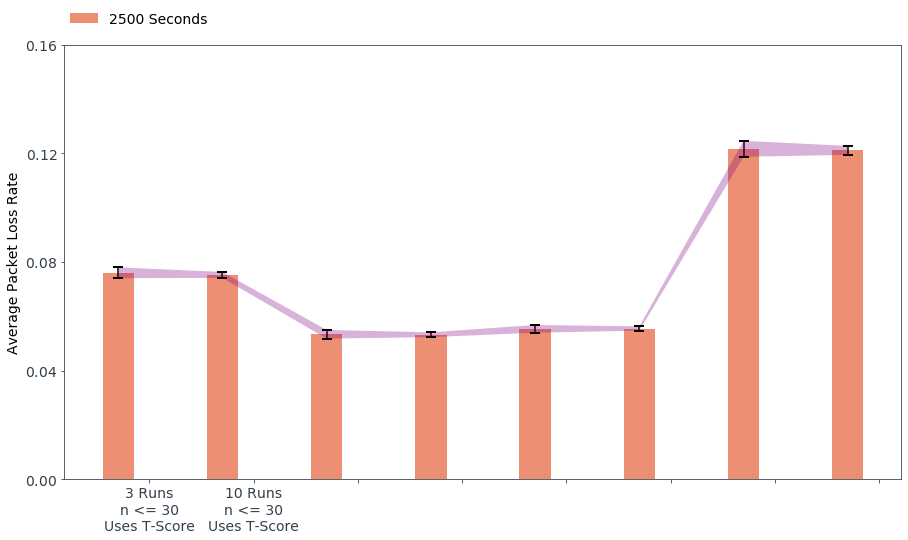

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats


class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: '/Users/royruiz/SimCN/a-team-2/SiMCN-Ex07/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_310_PK_Loss_Rate.csv',
                 2: '/Users/royruiz/SimCN/a-team-2/SiMCN-Ex07/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_310_PK_Loss_Rate.csv',
                 3: '/Users/royruiz/SimCN/a-team-2/SiMCN-Ex07/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_250_PK_Loss_Rate.csv',
                 4: '/Users/royruiz/SimCN/a-team-2/SiMCN-Ex07/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_250_PK_Loss_Rate.csv',
                 5: '/Users/royruiz/SimCN/a-team-2/SiMCN-Ex07/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_150_PK_Loss_Rate.csv',
                 6: '/Users/royruiz/SimCN/a-team-2/SiMCN-Ex07/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_150_PK_Loss_Rate.csv',
                 7: '/Users/royruiz/SimCN/a-team-2/SiMCN-Ex07/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_5_PK_Loss_Rate.csv',
                 8: '/Users/royruiz/SimCN/a-team-2/SiMCN-Ex07/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_5_PK_Loss_Rate.csv'
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'Avg_Loss_Rate']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)
        
        data = data.dropna()
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        avgPKL_2500s_arr = []

        for i in range(len(data)):
            if (df['timelimit'][i] == 1000):
                avgPKL_2500s_arr.append(df['Avg_Loss_Rate'][i])
                
        array = {'array_2500': avgPKL_2500s_arr}
        return array
    
    def SampleStDev(self, arr):
        sample_stdev = []
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = []
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = []
        for inner_array in arr.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        for number in range(1,9):
            file_number = number

            obj = Result_Analysis()
            mean = obj.sampleMean(obj.read_file(file_number))
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(obj.read_file(file_number))
            tscore = obj.tScore(confidence_interval, obj.read_file(file_number))

            t_score_l, t_score_r = obj.confInterval_t(obj.read_file(file_number), mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, obj.read_file(file_number), mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
            
        
        #Plot the data
            
        # width of the bars
        barWidth = 0.3
 
        # Choose the height of the bars
        bars_2500s = [mean_dict[i][0] for i in mean_dict]
        #bars_3000s = [mean_dict[i][1] for i in mean_dict]
        #bars_5000s = [mean_dict[i][2] for i in mean_dict]
        print(bars_2500s)
        
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        yer_2500s_l = [t_dict[1][0][0], t_dict[2][0][0], t_dict[3][0][0], t_dict[4][0][0], 
                       t_dict[5][0][0], t_dict[6][0][0], t_dict[7][0][0], t_dict[8][0][0]]
                       
        yer_2500s_u = [t_dict[1][0][1], t_dict[2][0][1], t_dict[3][0][1], t_dict[4][0][1], 
                       t_dict[5][0][1], t_dict[6][0][1], t_dict[7][0][1], t_dict[8][0][1]]
        
        #yer_3000s_l = [t_dict[1][1][0], t_dict[2][1][0], z_dict[3][1][0]]
        #yer_3000s_u = [t_dict[1][1][1], t_dict[2][1][1], z_dict[3][1][1]]
        
        #yer_5000s_l = [t_dict[1][2][0], t_dict[2][2][0], z_dict[3][2][0]]
        #yer_5000s_u = [t_dict[1][2][1], t_dict[2][2][1], z_dict[3][2][1]]
        
        # Choose the height of the confidence interval (error bars) for errorbar method
        yer_2500s = [(u - l)/2 for u, l in zip(yer_2500s_u, yer_2500s_l)]
        #yer_3000s = [(u - l)/2 for u, l in zip(yer_3000s_u, yer_3000s_l)]
        #yer_5000s = [(u - l)/2 for u, l in zip(yer_5000s_u, yer_5000s_l)]
        
        # The x position of bars
        r_2500s = np.arange(len(bars_2500s))
        #r_3000s = [x + barWidth for x in r_1000s]
        #r_5000s = [x + barWidth for x in r_3000s]

        plt.figure(figsize = (15,8))
        
        # Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#333F4B'
        plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 14})
        
        # Create 2500s bars
        plt.bar(r_2500s, bars_2500s, width = barWidth, color = '#ed8f72', label='2500 Seconds')
        plt.errorbar(r_2500s, bars_2500s, yerr=yer_2500s, color = 'black', capthick=2, capsize=5, fmt=' ')
        plt.fill_between(r_2500s, yer_2500s_l, yer_2500s_u, facecolor='Purple', alpha=0.3, zorder=2)
        
        # Create 3000s bars
        #plt.bar(r_3000s, bars_3000s, width = barWidth, color = '#d6d727', label='3000 Seconds')
        #plt.errorbar(r_3000s, bars_3000s, yerr=yer_3000s, color = 'black', capthick=2, capsize=5, fmt=' ')
        #plt.fill_between(r_3000s, yer_3000s_l, yer_3000s_u, facecolor='Purple', alpha=0.3, zorder=2)
        
        # Create 5000s bars
        #plt.bar(r_5000s, bars_5000s, width = barWidth, color = '#92cad1', label='5000 Seconds')
        #plt.errorbar(r_5000s, bars_5000s, yerr=yer_5000s, color = 'black', capthick=2, capsize=5, fmt=' ')
        #plt.fill_between(r_5000s, yer_5000s_l, yer_5000s_u, facecolor='Purple', alpha=0.3, zorder=2)
        
        # General layout
        plt.xticks([r + barWidth for r in range(len(bars_2500s))], ['3 Runs\nn <= 30\nUses T-Score',
                                                                  '10 Runs\nn <= 30\nUses T-Score'])
        plt.yticks(np.arange(0, 0.2, 0.04))
        plt.ticklabel_format(axis='y', useMathText=True)
        
        plt.ylabel('Average Packet Loss Rate')
        plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.03), ncol=3,
            borderaxespad=0, frameon=False)

        # Show graphic
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 

In [1]:
%matplotlib inline


Please enter the desired confidence interval: .95


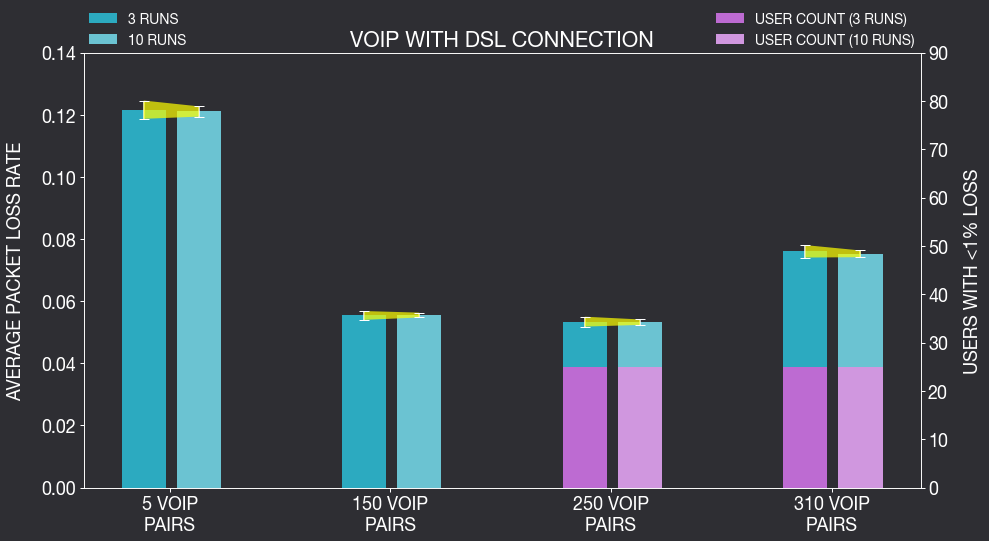

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_5_PK_Loss_Rate.csv',
                 2: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_150_PK_Loss_Rate.csv',
                 3: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_250_PK_Loss_Rate.csv',
                 4: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_310_PK_Loss_Rate.csv',
                 5: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_5_PK_Loss_Rate.csv',
                 6: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_150_PK_Loss_Rate.csv',
                 7: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_250_PK_Loss_Rate.csv',
                 8: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_310_PK_Loss_Rate.csv'
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'Avg_Loss_Rate']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        avgPKL_1000s_arr = []
        avgPKL_user_count = 0

        for i in range(len(data)):
            if (df['timelimit'][i] == 1000):
                avgPKL_1000s_arr.append(df['Avg_Loss_Rate'][i])
                
        for i in range(len(data)):
            if (df['Avg_Loss_Rate'][i] < 0.01):
                avgPKL_user_count += 1
           
        array = {'array_2500': avgPKL_1000s_arr}
        count = avgPKL_user_count
        return array, count
    
    def SampleStDev(self, arr):
        sample_stdev = []
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = []
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = []
        for inner_array in arr.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        user_count_arr = []
        for number in range(1,9):
            file_number = number
            
            obj = Result_Analysis()
            array, count = obj.read_file(file_number)
            user_count_arr.append(count)
            mean = obj.sampleMean(array)
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(array)
            tscore = obj.tScore(confidence_interval, array)

            t_score_l, t_score_r = obj.confInterval_t(array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
        
        #Plot the data
            
        # width of the bars
        barWidth = 0.2
        # Choose the height of the bars
        #for key,value in mean_dict.items():
        
        bars_count_rpt03 = [math.ceil(user_count_arr[index]/3) for index, value in enumerate(user_count_arr) if index <= 3]
        bars_count_rpt10 = [math.ceil(user_count_arr[index]/10) for index, value in enumerate(user_count_arr) if index > 3]
        #print(bars_count_rpt03, bars_count_rpt10, sep=" ")
        
        bars_1000s_rpt03 = [mean_dict[i][0] for i in mean_dict if i <= 4]
        bars_1000s_rpt10 = [mean_dict[i][0] for i in mean_dict if i > 4]
        #bars_5000s = [mean_dict[i][2] for i in mean_dict]
        #print(bar_1000s_rpt03)
        #print(bars_1000s_rpt10)
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        yer_1000s_l_rpt03 = [t_dict[1][0][0], t_dict[2][0][0], t_dict[3][0][0], t_dict[4][0][0]]
                       
        yer_1000s_u_rpt03 = [t_dict[1][0][1], t_dict[2][0][1], t_dict[3][0][1], t_dict[4][0][1]]
        
        yer_1000s_l_rpt10 = [t_dict[5][0][0], t_dict[6][0][0], t_dict[7][0][0], t_dict[8][0][0]]
        
        yer_1000s_u_rpt10 = [t_dict[5][0][1], t_dict[6][0][1], t_dict[7][0][1], t_dict[8][0][1]]
        
        #yer_5000s_l = [t_dict[1][2][0], t_dict[2][2][0], z_dict[3][2][0]]
        #yer_5000s_u = [t_dict[1][2][1], t_dict[2][2][1], z_dict[3][2][1]]
        
        # Choose the height of the confidence interval (error bars) for errorbar method
        yer_1000s_rpt03 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt03, yer_1000s_l_rpt03)]
        yer_1000s_rpt10 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt10, yer_1000s_l_rpt10)]
        #yer_5000s = [(u - l)/2 for u, l in zip(yer_5000s_u, yer_5000s_l)]
        
        # The x position of bars
        r_1000s_rpt03 = np.arange(len(bars_1000s_rpt03))
        r_1000s_rpt10 = [x + barWidth + .05 for x in r_1000s_rpt03]
        #r_5000s = [x + barWidth for x in r_3000s]

        
        
        #plt.figure(figsize = (15,8))
        #Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#FFFFFF'
        plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'white'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'white'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, ax1 = plt.subplots(figsize=(15, 8), facecolor = (0.18, 0.18, 0.2))
        ax1.set_facecolor((0.18, 0.18, 0.2))
        ax2 = ax1.twinx()
        
        # Create 1000s_rpt03 bars
        ax1.bar(r_1000s_rpt03, bars_1000s_rpt03, width = barWidth, color = '#2CAAC0', label='3 RUNS')
        ax1.errorbar(r_1000s_rpt03, bars_1000s_rpt03, yerr=yer_1000s_rpt03, color = 'white', capthick=1, capsize=5, fmt=' ')
        #plt.fill_between(r_1000s_rpt03, yer_1000s_l_rpt03, yer_1000s_u_rpt03, facecolor='Purple', alpha=0.3, zorder=2)
        
        # Create 1000s_rpt10 bars
        ax1.bar(r_1000s_rpt10, bars_1000s_rpt10, width = barWidth, color = '#6BC3D2', label='10 RUNS')
        ax1.errorbar(r_1000s_rpt10, bars_1000s_rpt10, yerr=yer_1000s_rpt10, color = 'white', capthick=1, capsize=5, fmt=' ')
        #plt.fill_between(r_1000s_rpt10, yer_1000s_l_rpt10, yer_1000s_u_rpt10, facecolor='Purple', alpha=0.3, zorder=2)
        
        r_pairs = [[x, y] for x,y in zip(r_1000s_rpt03, r_1000s_rpt10)]
        yer_l = [[x,y] for x,y in zip(yer_1000s_l_rpt03, yer_1000s_l_rpt10)]
        yer_u = [[x,y] for x,y in zip(yer_1000s_u_rpt03, yer_1000s_u_rpt10)]
        
        for i in range(len(r_pairs)):
            ax1.fill_between(r_pairs[i], yer_l[i], yer_u[i], facecolor='yellow', alpha=0.7, zorder=2)
        
        ax2.bar(r_1000s_rpt03, bars_count_rpt03, width = barWidth, color = '#BD6BD2', label='USER COUNT (3 RUNS)')
        ax2.bar(r_1000s_rpt10, bars_count_rpt10, width = barWidth, color = '#D097DF', label='USER COUNT (10 RUNS)')
        
        # Create 5000s bars
        #plt.bar(r_5000s, bars_5000s, width = barWidth, color = '#92cad1', label='5000 Seconds')
        #plt.errorbar(r_5000s, bars_5000s, yerr=yer_5000s, color = 'black', capthick=2, capsize=5, fmt=' ')
        #plt.fill_between(r_5000s, yer_5000s_l, yer_5000s_u, facecolor='Purple', alpha=0.3, zorder=2)
        
        # General layout
        

        #color = 'tab:red'
        
        #ax1.set_ylabel('exp', color=color)
        #ax1.plot(t, data1, color=color)
        #ax1.tick_params(axis='y', labelcolor=color)
        
        #ax1.set_xticks([r + barWidth/2 for r in range(len(bars_1000s_rpt03))])
        #ax1.set_xticklabels()
        #ax1.set_xlabel('User Pairs')
        
        labels = ['5 VOIP\nPAIRS','150 VOIP\nPAIRS','250 VOIP\nPAIRS', '310 VOIP\nPAIRS']
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x+0.119)
        ax1.set_xticklabels(labels ,color = '#FFFFFF')
        #ax.legend()
        ax1.tick_params(direction='out', length=4, width=1, colors='w')
        #ax1.spines['bottom'].set_color('red')
        #ax1.spines['top'].set_color('red')

        ax1.set_yticks(np.arange(0, 0.14, 0.02))
        ax1.set_ylabel('AVERAGE PACKET LOSS RATE', labelpad=16, color = '#FFFFFF')
        #ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        #color = 'tab:blue'
        #ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
        #ax2.plot(t, data2, color=color)
       # ax2.tick_params(axis='y', labelcolor=color)

        #fig.tight_layout()  # otherwise the right y-label is slightly clipped
       
        #plt.set_xlim(-width,len(ind)+width)
        #ax.set_ylim(0, 0.2)
        
        #ax2.set_ylim(0, 100)
        
        ax2.set_yticks(np.arange(0, 100, 10))
        ax2.tick_params(direction='out', length=4, width=1, colors='w')
        ax2.set_ylabel('USERS WITH <1% LOSS', labelpad=16, color = '#FFFFFF')
        ax1.set_title('VOIP WITH DSL CONNECTION', color = '#FFFFFF')
        #plt.show()
        #xTickMarks = dataset[0]
        #plt.set_xticks(ind+width)
        #xtickNames = ax.set_xticklabels(xTickMarks)
        #plt.setp(xtickNames, rotation=90, fontsize=10)
        
        #import pylab as plt
        #l = ax2.legend()
        
        #for text in l.get_texts():
        #    text.set_color("white")
        
        #plt.ticklabel_format(axis='y', useMathText=True)
        
        #plt.ylabel('Average Packet Loss Rate')
        
        #ax1.legend().set_color("white")
        
        leg1 = ax1.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (1.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        for text in leg1.get_texts():
            text.set_color("white")
        for text in leg2.get_texts():
            text.set_color("white")
        
        #leg1 = ax1.legend()
        #leg2 = ax2.legend()
        #for handle, text in zip(leg1.legendHandles, leg1.get_texts()):
        #    text.set_color("white")
        #    handle.set_color("black")
        #for handle, text in zip(leg2.legendHandles, leg2.get_texts()):
        #    text.set_color("white")
        
        #for text in 
        
        # Show graphic
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 


Please enter the desired confidence interval: .95


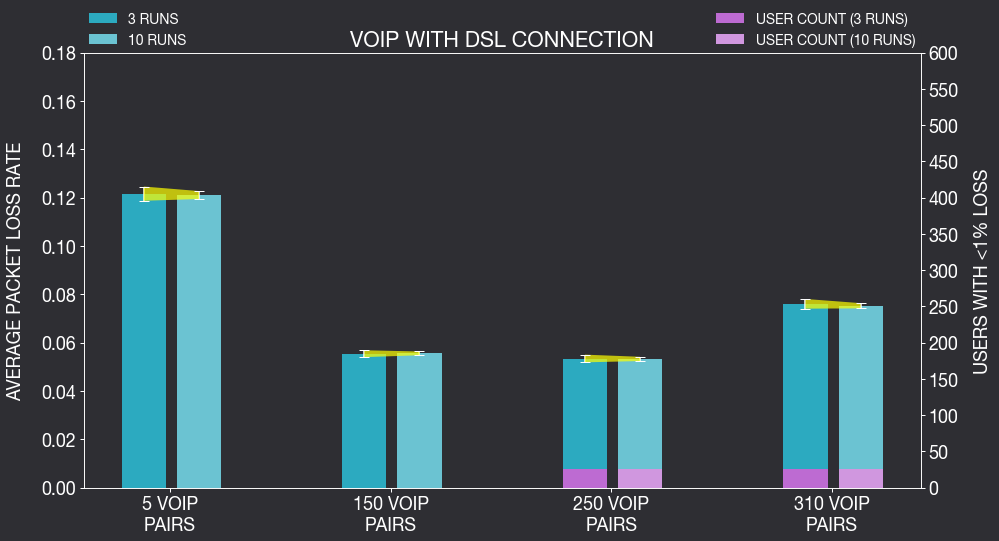

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_5_PK_Loss_Rate.csv',
                 2: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_150_PK_Loss_Rate.csv',
                 3: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_250_PK_Loss_Rate.csv',
                 4: path+'/New_results/VOIP_DSL_rpt03_scenario_04_PAIRS_310_PK_Loss_Rate.csv',
                 5: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_5_PK_Loss_Rate.csv',
                 6: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_150_PK_Loss_Rate.csv',
                 7: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_250_PK_Loss_Rate.csv',
                 8: path+'/New_results/VOIP_DSL_rpt10_scenario_04_PAIRS_310_PK_Loss_Rate.csv'
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'Avg_Loss_Rate']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        avgPKL_1000s_arr = []
        avgPKL_user_count = 0

        for i in range(len(data)):
            if (df['timelimit'][i] == 1000):
                avgPKL_1000s_arr.append(df['Avg_Loss_Rate'][i])
                
        for i in range(len(data)):
            if (df['Avg_Loss_Rate'][i] < 0.01):
                avgPKL_user_count += 1
           
        array = {'array_2500': avgPKL_1000s_arr}
        count = avgPKL_user_count
        return array, count
    
    def SampleStDev(self, arr):
        sample_stdev = []
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = []
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = []
        for inner_array in arr.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        user_count_arr = []
        for number in range(1,9):
            file_number = number
            
            obj = Result_Analysis()
            array, count = obj.read_file(file_number)
            user_count_arr.append(count)
            mean = obj.sampleMean(array)
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(array)
            tscore = obj.tScore(confidence_interval, array)

            t_score_l, t_score_r = obj.confInterval_t(array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
        
        #Plot the data
            
        # width of the bars
        barWidth = 0.2
        
        # Choose the height of the bars
        bars_count_rpt03 = [math.ceil(user_count_arr[index]/3) for index, value in enumerate(user_count_arr) if index <= 3]
        bars_count_rpt10 = [math.ceil(user_count_arr[index]/10) for index, value in enumerate(user_count_arr) if index > 3]
        
        bars_1000s_rpt03 = [mean_dict[i][0] for i in mean_dict if i <= 4]
        bars_1000s_rpt10 = [mean_dict[i][0] for i in mean_dict if i > 4]
        
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        yer_1000s_l_rpt03 = [t_dict[1][0][0], t_dict[2][0][0], t_dict[3][0][0], t_dict[4][0][0]]
                       
        yer_1000s_u_rpt03 = [t_dict[1][0][1], t_dict[2][0][1], t_dict[3][0][1], t_dict[4][0][1]]
        
        yer_1000s_l_rpt10 = [t_dict[5][0][0], t_dict[6][0][0], t_dict[7][0][0], t_dict[8][0][0]]
        
        yer_1000s_u_rpt10 = [t_dict[5][0][1], t_dict[6][0][1], t_dict[7][0][1], t_dict[8][0][1]]
                
        # Choose the height of the confidence interval (error bars) for errorbar method
        yer_1000s_rpt03 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt03, yer_1000s_l_rpt03)]
        yer_1000s_rpt10 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt10, yer_1000s_l_rpt10)]
        
        # The x position of bars
        r_1000s_rpt03 = np.arange(len(bars_1000s_rpt03))
        r_1000s_rpt10 = [x + barWidth + .05 for x in r_1000s_rpt03]

        #Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#FFFFFF'
        plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'white'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'white'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, ax1 = plt.subplots(figsize=(15, 8), facecolor = (0.18, 0.18, 0.2))
        ax1.set_facecolor((0.18, 0.18, 0.2))
        ax2 = ax1.twinx()
        
        # Create 1000s_rpt03 bars
        ax1.bar(r_1000s_rpt03, bars_1000s_rpt03, width = barWidth, color = '#2CAAC0', label='3 RUNS')
        ax1.errorbar(r_1000s_rpt03, bars_1000s_rpt03, yerr=yer_1000s_rpt03, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        # Create 1000s_rpt10 bars
        ax1.bar(r_1000s_rpt10, bars_1000s_rpt10, width = barWidth, color = '#6BC3D2', label='10 RUNS')
        ax1.errorbar(r_1000s_rpt10, bars_1000s_rpt10, yerr=yer_1000s_rpt10, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        r_pairs = [[x, y] for x,y in zip(r_1000s_rpt03, r_1000s_rpt10)]
        yer_l = [[x,y] for x,y in zip(yer_1000s_l_rpt03, yer_1000s_l_rpt10)]
        yer_u = [[x,y] for x,y in zip(yer_1000s_u_rpt03, yer_1000s_u_rpt10)]
        
        for i in range(len(r_pairs)):
            ax1.fill_between(r_pairs[i], yer_l[i], yer_u[i], facecolor='yellow', alpha=0.7, zorder=2)
        
        ax2.bar(r_1000s_rpt03, bars_count_rpt03, width = barWidth, color = '#BD6BD2', label='USER COUNT (3 RUNS)')
        ax2.bar(r_1000s_rpt10, bars_count_rpt10, width = barWidth, color = '#D097DF', label='USER COUNT (10 RUNS)')
        
        
        labels = ['5 VOIP\nPAIRS','150 VOIP\nPAIRS','250 VOIP\nPAIRS', '310 VOIP\nPAIRS']
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x+0.119)
        ax1.set_xticklabels(labels ,color = '#FFFFFF')
        ax1.tick_params(direction='out', length=4, width=1, colors='w')
        
        ax1.set_yticks(np.arange(0, 0.20, 0.02))
        ax1.set_ylabel('AVERAGE PACKET LOSS RATE', labelpad=16, color = '#FFFFFF')
        
        ax2.set_yticks(np.arange(0, 650, 50))
        ax2.tick_params(direction='out', length=4, width=1, colors='w')
        ax2.set_ylabel('USERS WITH <1% LOSS', labelpad=16, color = '#FFFFFF')
        ax1.set_title('VOIP WITH DSL CONNECTION', color = '#FFFFFF')
        
        leg1 = ax1.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (1.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        for text in leg1.get_texts():
            text.set_color("white")
        for text in leg2.get_texts():
            text.set_color("white")
        
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 


Please enter the desired confidence interval: .95


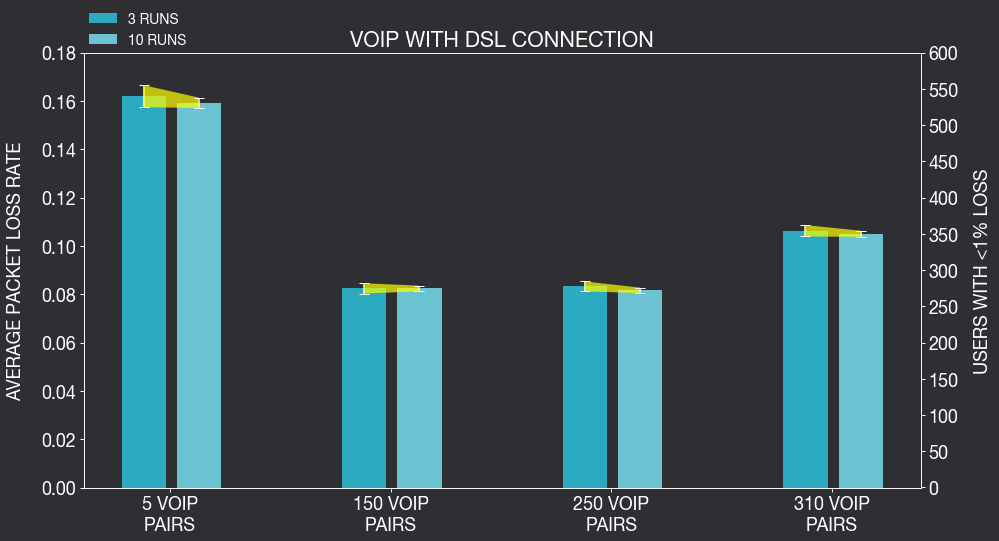

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: path+'/New_results/VOIP_DSL_rpt03_scenario_05_PAIRS_5_PK_Loss_Rate.csv',
                 2: path+'/New_results/VOIP_DSL_rpt03_scenario_05_PAIRS_150_PK_Loss_Rate.csv',
                 3: path+'/New_results/VOIP_DSL_rpt03_scenario_05_PAIRS_250_PK_Loss_Rate.csv',
                 4: path+'/New_results/VOIP_DSL_rpt03_scenario_05_PAIRS_310_PK_Loss_Rate.csv',
                 5: path+'/New_results/VOIP_DSL_rpt10_scenario_05_PAIRS_5_PK_Loss_Rate.csv',
                 6: path+'/New_results/VOIP_DSL_rpt10_scenario_05_PAIRS_150_PK_Loss_Rate.csv',
                 7: path+'/New_results/VOIP_DSL_rpt10_scenario_05_PAIRS_250_PK_Loss_Rate.csv',
                 8: path+'/New_results/VOIP_DSL_rpt10_scenario_05_PAIRS_310_PK_Loss_Rate.csv'
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'Avg_Loss_Rate']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        avgPKL_1000s_arr = []
        avgPKL_user_count = 0

        for i in range(len(data)):
            if (df['timelimit'][i] == 1000):
                avgPKL_1000s_arr.append(df['Avg_Loss_Rate'][i])
                
        for i in range(len(data)):
            if (df['Avg_Loss_Rate'][i] < 0.01):
                avgPKL_user_count += 1
           
        array = {'array_2500': avgPKL_1000s_arr}
        count = avgPKL_user_count
        return array, count
    
    def SampleStDev(self, arr):
        sample_stdev = []
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = []
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = []
        for inner_array in arr.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        user_count_arr = []
        for number in range(1,9):
            file_number = number
            
            obj = Result_Analysis()
            array, count = obj.read_file(file_number)
            user_count_arr.append(count)
            mean = obj.sampleMean(array)
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(array)
            tscore = obj.tScore(confidence_interval, array)

            t_score_l, t_score_r = obj.confInterval_t(array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
        
        #Plot the data
            
        # width of the bars
        barWidth = 0.2
        
        # Choose the height of the bars
        bars_count_rpt03 = [math.ceil(user_count_arr[index]/3) for index, value in enumerate(user_count_arr) if index <= 3]
        bars_count_rpt10 = [math.ceil(user_count_arr[index]/10) for index, value in enumerate(user_count_arr) if index > 3]
        
        bars_1000s_rpt03 = [mean_dict[i][0] for i in mean_dict if i <= 4]
        bars_1000s_rpt10 = [mean_dict[i][0] for i in mean_dict if i > 4]
        
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        yer_1000s_l_rpt03 = [t_dict[1][0][0], t_dict[2][0][0], t_dict[3][0][0], t_dict[4][0][0]]
                       
        yer_1000s_u_rpt03 = [t_dict[1][0][1], t_dict[2][0][1], t_dict[3][0][1], t_dict[4][0][1]]
        
        yer_1000s_l_rpt10 = [t_dict[5][0][0], t_dict[6][0][0], t_dict[7][0][0], t_dict[8][0][0]]
        
        yer_1000s_u_rpt10 = [t_dict[5][0][1], t_dict[6][0][1], t_dict[7][0][1], t_dict[8][0][1]]
                
        # Choose the height of the confidence interval (error bars) for errorbar method
        yer_1000s_rpt03 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt03, yer_1000s_l_rpt03)]
        yer_1000s_rpt10 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt10, yer_1000s_l_rpt10)]
        
        # The x position of bars
        r_1000s_rpt03 = np.arange(len(bars_1000s_rpt03))
        r_1000s_rpt10 = [x + barWidth + .05 for x in r_1000s_rpt03]

        #Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#FFFFFF'
        plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'white'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'white'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, ax1 = plt.subplots(figsize=(15, 8), facecolor = (0.18, 0.18, 0.2))
        ax1.set_facecolor((0.18, 0.18, 0.2))
        ax2 = ax1.twinx()
        
        # Create 1000s_rpt03 bars
        ax1.bar(r_1000s_rpt03, bars_1000s_rpt03, width = barWidth, color = '#2CAAC0', label='3 RUNS')
        ax1.errorbar(r_1000s_rpt03, bars_1000s_rpt03, yerr=yer_1000s_rpt03, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        # Create 1000s_rpt10 bars
        ax1.bar(r_1000s_rpt10, bars_1000s_rpt10, width = barWidth, color = '#6BC3D2', label='10 RUNS')
        ax1.errorbar(r_1000s_rpt10, bars_1000s_rpt10, yerr=yer_1000s_rpt10, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        r_pairs = [[x, y] for x,y in zip(r_1000s_rpt03, r_1000s_rpt10)]
        yer_l = [[x,y] for x,y in zip(yer_1000s_l_rpt03, yer_1000s_l_rpt10)]
        yer_u = [[x,y] for x,y in zip(yer_1000s_u_rpt03, yer_1000s_u_rpt10)]
        
        for i in range(len(r_pairs)):
            ax1.fill_between(r_pairs[i], yer_l[i], yer_u[i], facecolor='yellow', alpha=0.7, zorder=2)
        
        ax2.bar(r_1000s_rpt03, bars_count_rpt03, width = barWidth, color = '#BD6BD2', label='USER COUNT (3 RUNS)')
        ax2.bar(r_1000s_rpt10, bars_count_rpt10, width = barWidth, color = '#D097DF', label='USER COUNT (10 RUNS)')
        
        
        labels = ['5 VOIP\nPAIRS','150 VOIP\nPAIRS','250 VOIP\nPAIRS', '310 VOIP\nPAIRS']
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x+0.119)
        ax1.set_xticklabels(labels ,color = '#FFFFFF')
        ax1.tick_params(direction='out', length=4, width=1, colors='w')
        
        ax1.set_yticks(np.arange(0, 0.20, 0.02))
        ax1.set_ylabel('AVERAGE PACKET LOSS RATE', labelpad=16, color = '#FFFFFF')
        
        ax2.set_yticks(np.arange(0, 650, 50))
        ax2.tick_params(direction='out', length=4, width=1, colors='w')
        ax2.set_ylabel('USERS WITH <1% LOSS', labelpad=16, color = '#FFFFFF')
        ax1.set_title('VOIP WITH DSL CONNECTION', color = '#FFFFFF')
        
        leg1 = ax1.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        #leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (1.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        for text in leg1.get_texts():
            text.set_color("white")
        #for text in leg2.get_texts():
        #    text.set_color("white")
        
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 


Please enter the desired confidence interval: .95


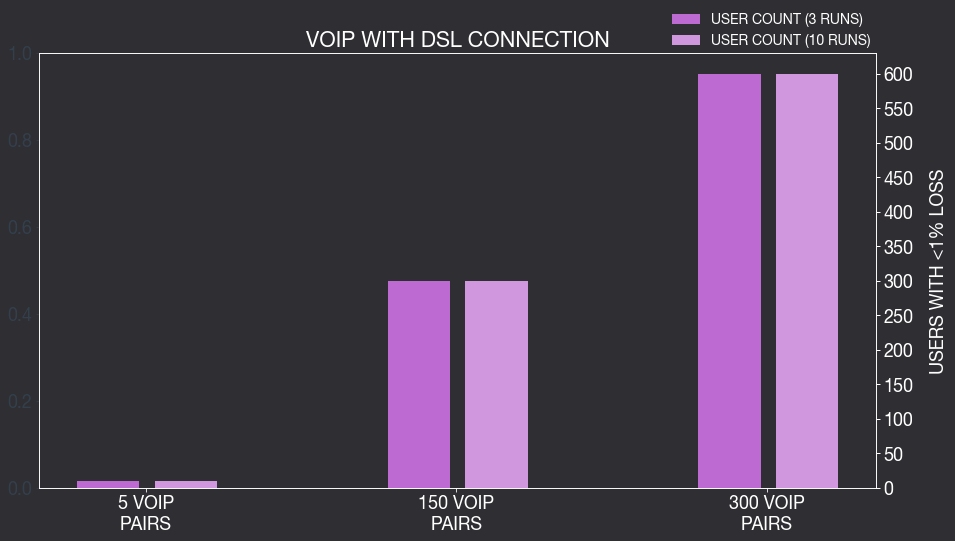

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats
import os

path = os.getcwd()

class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_5_PK_Loss_Rate.csv',
                 2: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_150_PK_Loss_Rate.csv',
                 3: path+'/New_results/VOIP_DSL_rpt03_scenario_03_PAIRS_300_PK_Loss_Rate.csv',
                 4: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_5_PK_Loss_Rate.csv',
                 5: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_150_PK_Loss_Rate.csv',
                 6: path+'/New_results/VOIP_DSL_rpt10_scenario_03_PAIRS_300_PK_Loss_Rate.csv'
                }
        cols = ['run', 'timelimit', 'repetition', 'Module', 'Name', 'Avg_Loss_Rate']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        data = data.dropna()
        data = data.reset_index(drop=True)
        df = pd.DataFrame(data)
        
        avgPKL_1000s_arr = []
        avgPKL_user_count = 0

        for i in range(len(data)):
            if (df['timelimit'][i] == 1000):
                avgPKL_1000s_arr.append(df['Avg_Loss_Rate'][i]*100)
                
        for i in range(len(data)):
            if (df['Avg_Loss_Rate'][i] < 0.01):
                avgPKL_user_count += 1
           
        array = {'array_2500': avgPKL_1000s_arr}
        count = avgPKL_user_count
        return array, count
    
    def SampleStDev(self, arr):
        sample_stdev = []
        for key, value in arr.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arr):
        sample_mean = []
        for key, value in arr.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    #  We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    #  we assume two sided t-value for normal distribution and degree freedom is one less than the length of the array.
    def tScore(self, conf, arr):
        t_scores = []
        for inner_array in arr.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array)-1)) 
        return t_scores


    def confInterval_t(self, arr, sample_mean, sample_stdev, t_scores):
        for inner_array in arr.values():
            length = len(inner_array)
        
        upper_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arr, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arr.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("\nPlease enter the desired confidence interval: "))
        if confidence_interval >= 1 or 0 >= confidence_interval:
            raise Exception 
                   
    except:
        print("Please enter a valid number from [0, 1)!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        user_count_arr = []
        for number in range(1,7):
            file_number = number
            
            obj = Result_Analysis()
            array, count = obj.read_file(file_number)
            user_count_arr.append(count)
            mean = obj.sampleMean(array)
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(array)
            tscore = obj.tScore(confidence_interval, array)

            t_score_l, t_score_r = obj.confInterval_t(array, mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, array, mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
        
        #Plot the data
            
        # width of the bars
        barWidth = 0.2
        
        # Choose the height of the bars
        bars_count_rpt03 = [math.ceil(user_count_arr[index]/3) for index, value in enumerate(user_count_arr) if index <= 2]
        bars_count_rpt10 = [math.ceil(user_count_arr[index]/10) for index, value in enumerate(user_count_arr) if index > 2]
        
        bars_1000s_rpt03 = [mean_dict[i][0] for i in mean_dict if i <= 3]
        bars_1000s_rpt10 = [mean_dict[i][0] for i in mean_dict if i > 3]
        
        # Upper and lower limits for confidence interval (error bars) used for fill_between method
        yer_1000s_l_rpt03 = [t_dict[1][0][0], t_dict[2][0][0], t_dict[3][0][0]]
                       
        yer_1000s_u_rpt03 = [t_dict[1][0][1], t_dict[2][0][1], t_dict[3][0][1]]
        
        yer_1000s_l_rpt10 = [t_dict[4][0][0], t_dict[5][0][0], t_dict[6][0][0]]
        
        yer_1000s_u_rpt10 = [t_dict[4][0][1], t_dict[5][0][1], t_dict[6][0][1]]
                
        # Choose the height of the confidence interval (error bars) for errorbar method
        yer_1000s_rpt03 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt03, yer_1000s_l_rpt03)]
        yer_1000s_rpt10 = [(u - l)/2 for u, l in zip(yer_1000s_u_rpt10, yer_1000s_l_rpt10)]
        
        # The x position of bars
        r_1000s_rpt03 = np.arange(len(bars_1000s_rpt03))
        r_1000s_rpt10 = [x + barWidth + .05 for x in r_1000s_rpt03]

        #Parameter setting for plotting
        #plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#FFFFFF'
        #plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'white'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'white'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        fig, ax1 = plt.subplots(figsize=(15, 8), facecolor = (0.18, 0.18, 0.2))
        ax1.set_facecolor((0.18, 0.18, 0.2))
        ax2 = ax1.twinx()
        
        # Create 1000s_rpt03 bars
        #ax1.bar(r_1000s_rpt03, bars_1000s_rpt03, width = barWidth, color = '#2CAAC0', label='3 RUNS')
        #ax1.errorbar(r_1000s_rpt03, bars_1000s_rpt03, yerr=yer_1000s_rpt03, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        # Create 1000s_rpt10 bars
        #ax1.bar(r_1000s_rpt10, bars_1000s_rpt10, width = barWidth, color = '#6BC3D2', label='10 RUNS')
        #ax1.errorbar(r_1000s_rpt10, bars_1000s_rpt10, yerr=yer_1000s_rpt10, color = 'white', capthick=1, capsize=5, fmt=' ')
        
        #r_pairs = [[x, y] for x,y in zip(r_1000s_rpt03, r_1000s_rpt10)]
        #yer_l = [[x,y] for x,y in zip(yer_1000s_l_rpt03, yer_1000s_l_rpt10)]
        #yer_u = [[x,y] for x,y in zip(yer_1000s_u_rpt03, yer_1000s_u_rpt10)]
        
        #for i in range(len(r_pairs)):
        #    ax1.fill_between(r_pairs[i], yer_l[i], yer_u[i], facecolor='yellow', alpha=0.7, zorder=2)
        
        ax2.bar(r_1000s_rpt03, bars_count_rpt03, width = barWidth, color = '#BD6BD2', label='USER COUNT (3 RUNS)')
        ax2.bar(r_1000s_rpt10, bars_count_rpt10, width = barWidth, color = '#D097DF', label='USER COUNT (10 RUNS)')
        
        
        labels = ['5 VOIP\nPAIRS','150 VOIP\nPAIRS','300 VOIP\nPAIRS']
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x+0.12)
        ax1.set_xticklabels(labels ,color = '#FFFFFF')
        #ax1.tick_params(direction='out', length=4, width=1, colors='w')
        
        #ax1.set_yticks(np.arange(0, 0.1, 0.02))
        #ax1.set_ylabel(' ', labelpad=16, color = '#FFFFFF')
        
        ax2.set_yticks(np.arange(0, 650, 50))
        ax2.tick_params(direction='out', length=4, width=1, colors='w')
        ax2.set_ylabel('USERS WITH <1% LOSS', labelpad=16, color = '#FFFFFF')
        ax1.set_title('VOIP WITH DSL CONNECTION', color = '#FFFFFF')
        
        #leg1 = ax1.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        leg2 = ax2.legend(fontsize = 14, loc='lower right', bbox_to_anchor= (1.0, 1.0), ncol=1, borderaxespad=0, frameon=False)
        #for text in leg1.get_texts():
        #    text.set_color("white")
        for text in leg2.get_texts():
            text.set_color("white")
        
        plt.show()
        
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False 